Initial import

In [1]:
from __future__ import print_function
from root_numpy import root2array, tree2array
import ROOT

Welcome to JupyROOT 6.12/06


#Get Data

In [2]:
rfile = ROOT.TFile("TreeFile.root")
intree = rfile.Get('Tree')
intree.Print()
# and convert the TTree into an array
array = tree2array(intree,branches=["Gen","Reco","dataGen","data"])
array.dtype.names = ('reco', "gen","data", "dataGen")

******************************************************************************
*Tree    :Tree      : Tree                                                   *
*Entries :  1000000 : Total =        16047680 bytes  File  Size =   14352984 *
*        :          : Tree compression factor =   1.12                       *
******************************************************************************
*Br    0 :Reco      : Reco/F                                                 *
*Entries :  1000000 : Total  Size=    4011767 bytes  File Size  =    3593746 *
*Baskets :      126 : Basket Size=      32000 bytes  Compression=   1.12     *
*............................................................................*
*Br    1 :Gen       : Gen/F                                                  *
*Entries :  1000000 : Total  Size=    4011637 bytes  File Size  =    3580256 *
*Baskets :      126 : Basket Size=      32000 bytes  Compression=   1.12     *
*...................................................

#Plot Data

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
df = pd.DataFrame(array)
#print(df)

NBins=20
xmin=0
xmax=1000
content_gen ,bins,patches = plt.hist(df['gen'], range=[xmin,xmax] ,bins=NBins)
plt.ylabel('# events')
plt.xlabel("gen")
plt.savefig("plots/gen.pdf")
plt.show()
plt.gcf().clear()

plt.hist(df['reco'], bins=bins)
plt.ylabel('# events')
plt.xlabel("reco")
plt.show()
plt.savefig("plots/reco.pdf")
plt.gcf().clear()

plt.hist2d(df['reco'],df['gen'], bins=bins, range=[[xmin, xmax], [xmin, xmax]],norm=LogNorm())
plt.ylabel('gen')
plt.xlabel('reco')
plt.colorbar()
plt.savefig("plots/data.pdf")
plt.show()
plt.gcf().clear()

#Do unfolding using NN

basic params

In [4]:
batch_size = 1000
num_classes = NBins
epochs = 2

#Keras Imports

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense,Flatten

/home/swieland/tools/root/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


#convert to categorical

In [31]:
binwidth=(xmax-xmin)/NBins
#GEN
gen=df["gen"]
bins_= bins[:-1].copy()
g=np.digitize(gen,bins_)-1
print(bins)
print(g)
print(bins_)
gcat = keras.utils.to_categorical(g,NBins)
#Reco
reco=df["reco"].values
r=np.digitize(reco,bins_)
r = r.reshape(r.shape[0],1,1)
#for test only
#rcat=keras.utils.to_categorical(r,NBins)

#dataReco
data=df["data"].values
data=np.digitize(data,bins_)
data = data.reshape(data.shape[0],1,1)
#dataGen
DataGen=df["dataGen"].values
DataGen=np.digitize(DataGen,bins_)-1
DataGencat = keras.utils.to_categorical(DataGen,NBins)

from sklearn.model_selection import train_test_split
r_train, r_test, g_train, g_test = train_test_split(r, gcat, test_size=0.2, random_state=42)

[   0.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.
  600.  650.  700.  750.  800.  850.  900.  950. 1000.]
[15 13  7 ...  7  8  4]
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600. 650.
 700. 750. 800. 850. 900. 950.]


#prepare model

In [32]:
def prepareModel(nvar=1, NBins=NBins, kappa=8):
    ''' Prepare KERAS-based sequential neural network with for ML unfolding. 
        Nvar defines number of inputvariables. NBins is number of truth bins. 
        kappa is an empirically tuned parameter for the intermediate layer'''
    model = Sequential()
    model.add(Dense(nvar,activation='linear',input_shape=(nvar,1)))
    model.add(Flatten())
    model.add(Dense(kappa*NBins**2,activation='relu'))

    # model.add(Dropout(0.25))
    # model.add(Dense(2*NBins,activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(NBins,activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model
model = prepareModel(1,NBins)

#fit model

In [33]:
from datetime import datetime
now = datetime.now()
logdir = "./logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
CallBack=keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
h = model.fit(r_train,g_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(r_test,g_test), callbacks=[CallBack])

Train on 800000 samples, validate on 200000 samples
Epoch 1/2
800000/800000 [==============================] - 24s 30us/step - loss: 1.6774 - acc: 0.3181 - val_loss: 1.5225 - val_acc: 0.3527
Epoch 2/2
800000/800000 [==============================] - 20s 25us/step - loss: 1.5142 - acc: 0.3528 - val_loss: 1.5033 - val_acc: 0.3596


2018-03-25 22:22:34.168616: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2


save model

In [34]:
model.save("model.hdf5")

evaluate model

In [35]:
loss_and_metrics = model.evaluate(r_test, g_test, batch_size=128)
print(loss_and_metrics)

200000/200000 [==============================] - 3s 16us/step
[1.5032890133666992, 0.35956]


test predictions

In [37]:
prob = model.predict(r_test, batch_size=128)
classes=prob.argmax(axis=-1)

for i in range(40):    
    print(classes[i],g_test.argmax(axis=-1)[i])

2 1
8 9
12 13
4 4
4 2
2 3
9 8
2 1
4 3
3 5
3 3
2 2
3 3
12 10
5 4
3 3
9 8
2 3
6 7
2 0
2 1
4 4
2 2
2 2
7 6
3 1
2 2
2 1
5 6
7 7
2 2
2 4
3 3
8 8
5 4
12 12
9 9
8 8
2 3
3 2


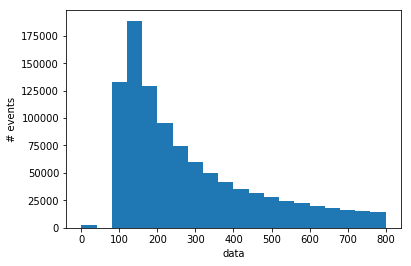

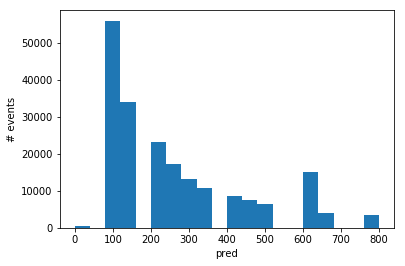

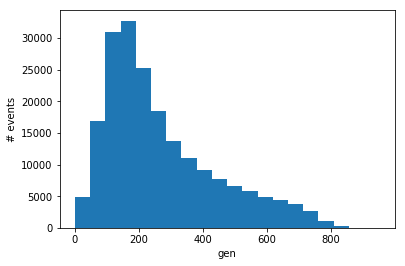

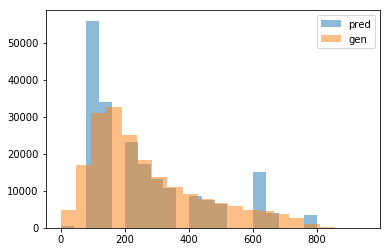

In [41]:
pred=classes*binwidth

plt.hist(df["data"] ,bins=NBins)
plt.ylabel('# events')
plt.xlabel("data")
plt.show()
plt.savefig("plots/pred.pdf")
plt.gcf().clear()

plt.hist(pred ,bins=NBins)
plt.ylabel('# events')
plt.xlabel("pred")
plt.show()
plt.savefig("plots/pred.pdf")
plt.gcf().clear()

plt.hist(g_test.argmax(axis=-1)*binwidth ,bins=NBins)
plt.ylabel('# events')
plt.xlabel("gen")
plt.show()
plt.gcf().clear()

plt.hist(pred, bins=NBins, alpha=0.5, label='pred')
plt.hist(g_test.argmax(axis=-1)*binwidth , bins=NBins, alpha=0.5, label='gen')
plt.legend(loc='upper right')
plt.show()